In [93]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

img_w = 64
img_h = 128
nbins = 9
cell_w_h = 8

cells_grid_columns = int(img_w/cell_w_h)
cells_grid_rows = int(img_h/cell_w_h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 64, 3) <class 'numpy.ndarray'>


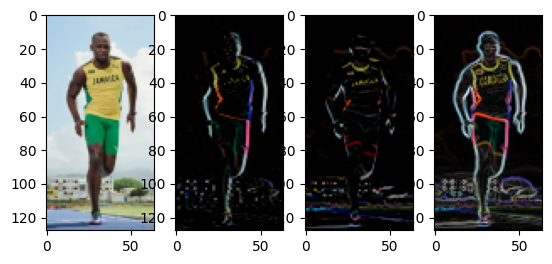

In [175]:
img_path = os.path.join(".","bolt_test_HOG.png")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape, type(img))

img = np.float32(img) / 255.0
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

mag, angles = cv2.cartToPolar(gx,gy, angleInDegrees=True)

fig, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(img, label='a')
ax[1].imshow(gx, label='b')
ax[2].imshow(gy, label='c')
ax[3].imshow(mag, label='d')
plt.show()

In [267]:
def ToBins(cell_dir:np.array, cell_mag:np.array):
    'Takes a 8x8 cell as input, and returns a np.array representing the HOG of that cell.'
    #direction angles in degrees!
    assert cell_dir.shape == (8,8,3), f"dir matrix should be shaped (8,8,3), but it's {cell_dir.shape}"
    assert cell_mag.shape == (8,8,3), f"mag matrix should be shaped (8,8,3), but it's {cell_mag.shape}"

    cell_dir = cell_dir % 180
    bins = np.zeros(shape=(nbins,3), dtype=np.float32)
    step = 180.0/nbins
    
    #in this array, idx 0 correspond to angle 180-step, and idx -1 correspond to angle 0
    angles = np.arange(-step,180.0+step,step)
    angles = angles[:,np.newaxis]   #for broadcasting

    #print(angles)
    for i in range(cell_w_h):
        for j in range(cell_w_h):
            dir, mag = cell_dir[i,j], cell_mag[i,j]
            diff = np.abs(angles-dir)
            idx_1 = np.argmin(diff, 0)
            tmp = diff[idx_1]
            diff[idx_1] = 180
            idx_2 = np.argmin(diff, 0)
            diff[idx_1] = tmp
            factor_1 = np.diag(1.0 - diff[idx_1] / step)
            factor_2 = np.diag(1.0 - diff[idx_2] / step)
            assert np.all(factor_1 >= 0), print(factor_1)
            assert np.all(factor_2 >= 0), print(factor_2)
            #now we just have to correct the indexes.
            idx_1 = np.where(idx_1==0, nbins-1, idx_1-1)
            idx_1 = np.where(idx_1==nbins, 0, idx_1)
            idx_2 = np.where(idx_2==0, nbins-1, idx_2-1)
            idx_2 = np.where(idx_2==nbins, 0, idx_2)
            bins[idx_1] = bins[idx_1] + factor_1 * mag
            bins[idx_2] = bins[idx_2] + factor_2 * mag
    return bins

def normalize(v:np.array):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

assert np.all(mag>=0), "Not all mags are >= 0."

hogs = np.empty([cells_grid_rows, cells_grid_columns, nbins,3], dtype=np.float32)
for i in range(cells_grid_rows):
    for j in range(cells_grid_columns):
       hogs[i,j] = ToBins(angles[i:i+8, j:j+8],mag[i:i+8, j:j+8])

assert np.all(hogs>=0), "Not all hog values are >= 0."

norm_hogs = np.empty([cells_grid_rows-1, cells_grid_columns-1, nbins,3], dtype=np.float32)
#let's create the norm matrix (15x7) --> 4 cells normalized in one block = 16x16 pixel block normalization
for i in range(cells_grid_rows-1):
    for j in range(cells_grid_columns-1):
        norm_hogs[i,j] = normalize(hogs[i:i+1,j:j+1])


[-0.17164478  0.5         0.5       ]


AssertionError: None

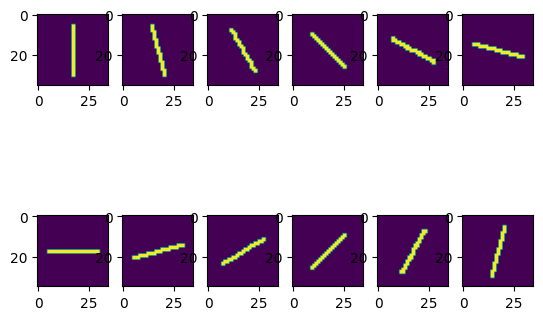

In [265]:
#visualization

def PlotAngle(angles:np.array, mags:np.array, thickness:int=1, plot_dim=35):
    assert plot_dim > 1, "plot_dimf must be greater than 1."
    assert thickness >= 1, "thickness must be greater then 0."
    assert angles.dtype is not np.float32 , f"dtype for tensor angles must be float32, but it's {angles.dtype}"
    assert mags.dtype is not np.float32 , f"dtype for tensor mags must be float32, but it's {mags.dtype}"
    assert mags.shape == angles.shape, f"tensor mags {mags.shape} has a different shape respect {angles.shape}"
    assert np.all(mags >= 0) and np.all(mags <= 1), f"mag's value should be between 0 and 1. You passed {mags}"
    margin = int(plot_dim/8)

    plot_matrix = np.zeros(shape=(plot_dim,plot_dim, angles.shape[0]), dtype=np.float32)
    #print(plot_matrix.shape)
    angles = angles*math.pi / 180.0
    dir = np.array([ -np.cos(angles), -np.sin(angles) ])
    cy = cx = round(plot_dim/2)

    #let's avoid negative lenghts
    lenghts = np.maximum(np.ceil(mags * plot_dim/2) -math.floor(thickness/2) - margin, 0)
    w1 = math.ceil(thickness/2)
    w2 = thickness - w1

    #let's iterate on the maximum number of pixels which could be written.
    for i in range( math.ceil(plot_dim/2) -math.floor(thickness/2) - margin):
        mov =  np.round(dir * i).astype(np.int16)
        dx_vec = mov[0,:]
        dy_vec = mov[1,:]

        for j in range(dx_vec.shape[0]): #probably this coudl be avoided and optimized..
            dx = dx_vec[j]
            dy = dy_vec[j]
            if(lenghts[j] >= i):
                plot_matrix[cx+dx-w1:cx+dx+w2,cy+dy-w1:cy+dy+w2,j] = 1
                plot_matrix[cx-dx-w1:cx-dx+w2,cy-dy-w1:cy-dy+w2,j] = 1
    return plot_matrix


#test 
test_angles = [x for x in range(0,180,15)]
test_angles = np.array(test_angles, dtype=np.float32)
#test_mags = np.random.random(size = test_angles.shape)
test_mags = np.ones(shape=test_angles.shape, dtype=np.float32)

mat = PlotAngle(test_angles,test_mags, thickness=2)

col_number = math.ceil(len(test_angles)/2)
fig, ax = plt.subplots(nrows=2, ncols=col_number)
for i in range(2):
    for j in range(col_number):
        idx = i*col_number + j
        if idx >= len(test_angles):
            idx = 0
        ax[i,j].imshow(mat[:,:,idx])
plt.show()

#before nparrays time was 1.1s


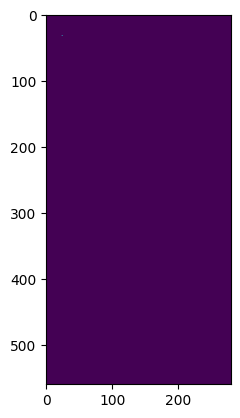

In [266]:
#visualize a full histogram
def PlotHistogram(histogram:np.array, plot_dim:int, thick=1):
    step = 180.0/nbins
    angles = np.arange(0,180,step)
    img = PlotAngle(angles,histogram, thickness=thick, plot_dim=plot_dim)
    out = np.max(img, -1)
    return out

#test
#print(norm_hogs[0,0,:,0])
#img = PlotHistogram(norm_hogs[13,2,:,0])
#plt.imshow(img)

def Get_HOG_Graphics(hogs:np.array,thick=1):
    plot_dim = 35
    red_image = np.empty(shape=(hogs.shape[0]*plot_dim, hogs.shape[1]*plot_dim))

    for i in range(hogs.shape[0]):
        for j in range(hogs.shape[1]):
            red_image[i:i+plot_dim, j:j+plot_dim] = PlotHistogram(hogs[i,j,:,0], plot_dim)
    return red_image

img = Get_HOG_Graphics(hogs)
plt.imshow(img)